# DS-GA 1018 Probabilistic Time Series Analysis

# Week 11 BPTT

In [1]:
### --- Basic packages we need --- ###
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
from pdb import set_trace
from scipy.signal import decimate

#Utility function, IGNORE
def split_weight_matrix(A, sizes, axis=1):
    """Splits a weight matrix along the specified axis (0 for row, 1 for
    column) into a list of sub arrays of size specified by 'sizes'."""

    idx = [0] + np.cumsum(sizes).tolist()
    if axis == 1:
        ret = [np.squeeze(A[:,idx[i]:idx[i+1]]) for i in range(len(idx) - 1)]
    elif axis == 0:
        ret = [np.squeeze(A[idx[i]:idx[i+1],:]) for i in range(len(idx) - 1)]
    return ret

To keep our implementation somewhat general, we'll define a Function class that is simply a way for a function *and* its derivative to be stored in one place.

In [2]:
class Function:
    """Defines a function and its derivative.
    
    Attributes:
        f (function): An element-wise differentiable function that acts on a
            1-d numpy array of arbitrary dimension. May include a second
            argument for a label, e.g. for softmax-cross-entropy.
        f_prime (function): The element-wise derivative of f with respect to
            the first argument, must also act on 1-d numpy arrays of arbitrary
            dimension.
    """
    
    def __init__(self, f, f_prime):
        """Inits an instance of Function by specifying f and f_prime."""
        
        self.f = f
        self.f_prime = f_prime

### Now we create useful instances of Function ###
        
#tanh

def tanh_(z):

    return np.tanh(z)

def tanh_derivative(z):
    
    return 1 - np.tanh(z)**2

tanh = Function(tanh_, tanh_derivative)

#identity

def identity_(z):
    
    return z

def identity_derivative(z):
    
    return np.ones_like(z)

identity = Function(identity_, identity_derivative)

#mean-squared error

def mean_squared_error_(z, y):
    
    return 0.5*np.square(z - y).mean()

def mean_squared_error_derivative(z, y):
    
    return z - y
    
mean_squared_error = Function(mean_squared_error_, mean_squared_error_derivative)

Below is our "RNN" class. An instance of RNN is used to run the process *forwards*, keeping track of relevant variables in the process.

\begin{align}
{\bf h}^{(t)} &= {\bf W}^{\text{rec}} {\bf a}^{(t-1)} + {\bf W}^{\text{in}} {\bf x}^{(t)} + {\bf b}^{\text{rec}}\\
{\bf a}^{(t)} &= \phi({\bf h}^{(t)})
\end{align}

It also projects to an output space via

\begin{align}
{\bf z}^{(t)} = {\bf W}^{\text{out}} {\bf a}^{(t)} + {\bf b}^{\text{out}}.
\end{align}

We call these z values the "pre-outputs," since they are not themselves the actual prediction, but rather that which is passed to some function $\psi$, e.g. sigmoid or softmax into a space of classes.(Think logits vs. actual classification probabilities.) We denote the prediction

\begin{align}
{\bf y}^{(t)}_{\text{hat}} = \psi({\bf z}^{(t)})
\end{align}

as "y_hat" in the code. (For the purpose of this lab, we will use the identity as $\psi$ for convenience.) Then we finally calculate the loss, but we actually do so as a function of ${\bf z}$ (and the training label ${\bf y}^{*(t)}$), with the output included in the loss function. This is because it's easier for certain types of losses with singularities, such as sigmoid- or softmax-cross-entropy.

\begin{align}
L^{(t)} = L({\bf z}^{(t)}, {\bf y}^{*(t)})
\end{align}

This loss *value* is denoted by "loss_", and the function that calculates it is "loss".

For the purpose of learning, we must also calculate the "Jacobian" of the network, which we include in the RNN class because the mathematical form of the Jacobian varies by RNN architecture---remember, these update equations are just one case of a more general $F_{\bf w}({\bf a}^{(t-1)}, {\bf x}^{(t)})$.

\begin{align}
J^{(t)}_{ij} = \partial a^{(t)}_i / \partial a^{(t-1)}_j = \phi'(h^{(t)}_i) W^{\text{rec}}_{ij}
\end{align}

TODO:

1. Fill in the "next_state" function that updates ${\bf h}$ and ${\bf a}$.
2. Fill in the "next_output" function that updates ${\bf z}$ and ${\bf y}_{\text{hat}}$
3. Fill in the "get_jacobian" function that calculates ${\bf J}$ based on the current values of ${\bf h}$ and ${\bf W}^{\text{rec}}$.

In [3]:
class RNN:
    """A vanilla recurrent neural network.

    Attributes:
        n_in (int): Number of input dimensions
        n_h (int): Number of hidden units
        n_out (int): Number of output dimensions
        W_in (numpy array): Array of shape (n_h, n_in), weights task inputs.
        W_rec (numpy array): Array of shape (n_h, n_h), weights recurrent
            inputs.
        W_out (numpy array): Array of shape (n_out, n_h), provides hidden-to-
            output-layer weights.
        b_rec (numpy array): Array of shape (n_h), represents the bias term
            in the recurrent update equation.
        params (list): The list of each parameter's current value, in the order
            [W_rec, W_in, b_rec, W_out, b_out].
        activation (functions.Function): An instance of the Function class
            used as the network's nonlinearity \phi in the recurrent update
            equation.
        output (functions.Function): An instance of the Function class used
            for calculating final output from z.
        loss (functions.Function): An instance of the Function class used for
            calculating loss from z (must implicitly include output function,
            e.g. softmax_cross_entropy if output is softmax).
        x (numpy array): Array of shape (n_in) representing the current inputs
            to the network.
        h (numpy array): Array of shape (n_h) representing the pre-activations
            of the network.
        a (numpy array): Array of shape (n_h) representing the post-activations
            of the network.
        z (numpy array): Array of shape (n_out) reprenting the outputs of the
            network, before any final output nonlinearities, e.g. softmax,
            are applied.
        error (numpy array): Array of shape (n_out) representing the derivative
            of the loss with respect to z. Calculated by loss.f_prime.
        y_hat (numpy array): Array of shape (n_out) representing the final
            outputs of the network, to be directly compared with task labels.
        *_prev (numpy array): Array representing any of x, h, a, or z at the
            previous time step."""

    def __init__(self, W_in, W_rec, W_out, b_rec, b_out,
                 activation, output, loss):
        """Initializes an RNN by specifying its initial parameter values,
        activation, output, and loss functions."""

        #Initial parameter values
        self.W_in = W_in
        self.W_rec = W_rec
        self.W_out = W_out
        self.b_rec = b_rec
        self.b_out = b_out

        #Network dimensions
        self.n_in = W_in.shape[1]
        self.n_h = W_in.shape[0]
        self.n_out = W_out.shape[0]

        #Check dimension consistency.
        assert self.n_h == W_rec.shape[0]
        assert self.n_h == W_rec.shape[1]
        assert self.n_h == W_in.shape[0]
        assert self.n_h == W_out.shape[1]
        assert self.n_h == b_rec.shape[0]
        assert self.n_out == b_out.shape[0]

        #Define shapes and params lists for convenience later.
        self.params = [self.W_rec, self.W_in, self.b_rec,
                       self.W_out, self.b_out]

        #Activation and loss functions
        self.activation = activation
        self.output = output
        self.loss = loss
        
        #Initial state values
        self.reset_network()

    def reset_network(self, sigma=1):
        
        self.h = np.random.normal(0, sigma, self.n_h)
        self.a = self.activation.f(self.h) #Specify activations by \phi.
        self.z = self.W_out.dot(self.a) + self.b_out #Specify outputs from a

    def next_state(self, x):
        """ FILL THIS FUNCTION IN 
        
        After copying the inputs and previous state variable into network
        attributes, update the new state variables self.a and self.h according
        to our forward pass equation.
        
        Arguments:
            x (numpy array, shape (n_in)): Input data for this time step
            
        Updates:
            self.h (numpy array, shape (n_h)): pre-activations
            self.a (numpy array, shape (n_h)): post-activations
        
        Returns:
            None"""
        
        self.x = x
        self.a_prev = np.copy(self.a)
        ### TODO ###
        # Update the new preactivation self.h using the network parameters
        # (think self.W_rec, etc.) and the current network state/inputs
        # (think self.x, self.h, etc.). Then update the post.activations
        # self.a using the network nonlinearity self.activation.f.

        #self.h = 0
        #self.a = 0
        self.h = self.W_rec.dot(self.a_prev) + self.W_in.dot(self.x)  + self.b_rec
        self.a = self.activation.f(self.h)
        

    def next_output(self):
        """ FILL THIS FUNCTION IN 
        
        After copying previous outputs into state variable, update the new state
        variable using the network's output parameters and the final output
        using the output activation function \psi.
        
        Arguments:
            None
            
        Updates:
            self.z (numpy array, shape (n_out)): pre-outputs
            self.y_hat (numpy array, shape (n_out)): final prediction
            
        Returns:
            None"""
        
        ### TODO ###
        ## Update the "pre-outputs" self.z via an (affine) linear
        ## function of the hidden state self.a using the network's
        ## output parameters. Then apply the output nonlinearity
        ## to update the final prediction y_hat.

        #self.z = 0
        #self.y_hat = 0
        self.z = self.W_out.dot(self.a) + self.b_out
        self.y_hat = self.output.f(self.z)

    def get_jacobian(self, h):
        """ FILL THIS FUNCTION IN
        
        Calculates the Jacobian matrix of the network using a given
        pre-activations vector h and the network, according to equation
        above.
        
        Hints:
        1) Be careful with numpy broadcasting rules!
        2) Use the f_prime attribute of self.activation.
        
        Arguments:
            h (numpy array, shape (n_h)): pre-activations
            
        Updates:
            None
            
        Returns:
            J (numpy array, shape (n_h, n_h)): the Jacobian matrix"""
        
        ### TODO ###
        ## Use equation ## to calculate the network
        ## Jacobian for a given pre-activations vector
        
        J = 0
        J = self.activation.f_prime (self.h.T)[None] * self.W_rec

        return J

Below is a wrapper for the whole RNN training process. The simulate function takes in

1. rnn (RNN instance)
2. data (dict): A dictionary with two keys: 'train' and 'test', each of which points to a dict with keys 'X' and 'Y' for inputs and labels, respectively. 
3. mode (string): A string that should take on the value either 'train' or 'test', indicating whether to using training or testing data *and* whether to pause on each time step to run learn_alg.
4. learn_alg (Learning_Algorithm instance)
5. monitors (list): A list of strings indicating which rnn attributes you want to store the entire history of during a simulation
6. T_max (int): Number of time steps to run loop for, if you don't want to go through all the data to save time.

It then loops through the total number of time steps (dictated by the content of "data" or user-specified T_max), runs the network forwards at each time step, and then if mode is 'train', the learning algorithm is updated and applied. A dictionary "mons" stores all values of whatever the user wants.

In [4]:
def simulate(rnn, data, mode='test', learn_alg=None, monitors=['loss_', 'y_hat'], T_max=np.inf):
        
        x_inputs = data[mode]['X']
        y_labels = data[mode]['Y']
        total_time_steps = int(np.minimum(x_inputs.shape[0], T_max))
        
        #Set initial network state
        rnn.reset_network()
        start_time = time.time()
        
        mons = {mon:[] for mon in monitors}
        for i_t in range(total_time_steps):
            
            #Forward pass, get errors
            x, y = x_inputs[i_t], y_labels[i_t]
            rnn.next_state(x)
            rnn.next_output()
            rnn.loss_ = rnn.loss.f(rnn.z, y)
            rnn.error = rnn.loss.f_prime(rnn.z, y)
            
            if mode == 'train':
                
                ## Update the memory content of the BPTT algorithm
                learn_alg.update()

                #Ever T_truncation time steps, update the network parameters
                if i_t % learn_alg.T_truncation == 0 and i_t > 0:
                
                    """ You will write this function in the Learning Algorithm code block """
                    ## Use the algorithm to calculate a *list* of gradients, 5 in total,
                    ## each of is a numpy array corresponding to one parameter:
                    ## W_rec, W_in, b_rec, W_out, b_rec
                    grads = learn_alg()

                    #Update parameters
                    for attr, grad in zip(['W_rec', 'W_in', 'b_rec', 'W_out', 'b_out'], grads):
                        old_param_value = getattr(rnn, attr)
                        new_param_value = old_param_value - learn_alg.lr * grad
                        setattr(rnn, attr, new_param_value)
            
            
            #IGNORE Update monitors
            for key in mons:
                try:
                    mons[key].append(getattr(rnn, key))
                except AttributeError:
                    pass
                
            if i_t % 10000 == 0 and i_t > 0:
                progress = np.round((i_t/total_time_steps)*100, 2)
                time_elapsed = np.round(time.time() - start_time, 1)

                summary = '\rProgress: {}% complete \nTime Elapsed: {}s \n'
                print(summary.format(progress, time_elapsed))

        #IGNORE Convert monitors from lists into numpy arrays
        for key in mons:
            try:
                mons[key] = np.array(mons[key])
            except ValueError:
                pass
            
        return rnn, mons

### Initialization
Run a "test" run first before we try to train anything. Start by initializing a network object. We could choose any initial parameter values we want, but in practice some work better than others. I suggest the following:

1. Initialize the bias vectors (recurrent and output) to 0
2. Initialize the input weight matrix to sample iid from a Gaussian with 0 mean and standard deviation $1/\sqrt{n_{
\text{in}}}$
3. Initialize the output weight matrix in the same way but with standard deviation $1/\sqrt{n_{
\text{hidden}}}$
4. Initialize the reucrrent weight matrix as a random othogonal matrix. One way to do this: start with a random matrix sampling iid from N(0,1), and then perform a QR decomposition on it, taking the ${\bf Q}$ matrix as the initial ${\bf W}^{\text{rec}}$. (Use the np.linalg.qr function.)

### Task
A note on the task. I have provided a data dictionary with training and test data, generated in the following way. The inputs are all iid Bernoulli samples with p = 0.5. (The second input dimension is simply the complement of the first, i.e. $x_1 = 1 - x_0$. We use input and output dimensions of 2 instead of 1 to make numpy broadcasting rules consistent.) The output has a baseline value of 0.5, which is increased by 0.5 if the input at 6 time steps ago is 1 and decreased by 0.25 if the input at 10 time steps back is 1. (The output is similarly 2-dimensional with a redundant second dimension.) Thus we have included 2 explicit intertemporal dependencies in the data. The network must continuously memorize the previous inputs and report the proper output.

TODO:
1. Initialize the network parameters and generate an initial RNN object. Then run a simulation in 'test' mode and plot the results.
2. Except for code blocks marked with IGNORE, make sure you understand the simulate function.

In [6]:
with open('./task_data.pkl', 'rb') as f:
    data = pickle.load(f)
    
n_in = 2
n_hidden = 32
n_out = 2

np.random.seed(0)

#Initialize input/output weights as 
W_in  = np.random.normal(0, np.sqrt(1/(n_in)), (n_hidden, n_in))
W_out = np.random.normal(0, np.sqrt(1/(n_hidden)), (n_out, n_hidden))

#Initialize recurrent weights with a random *orthogonal* matrix
W_rec = np.linalg.qr(np.random.normal(0, 1, (n_hidden, n_hidden)))[0]

#Initialize biases to 0
b_rec = np.zeros(n_hidden)
b_out = np.zeros(n_out)

#Initialize RNN object with these initial weights, \phi = tanh, \psi = I, L = MSE
rnn = RNN(W_in, W_rec, W_out, b_rec, b_out,
         activation=tanh,
         output=identity,
         loss=mean_squared_error)

rnn, mons = simulate(rnn, data)

(100.0, 200.0)

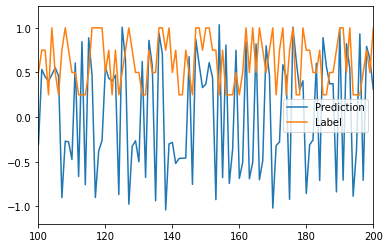

In [7]:
### --- PLOT RESULTS --- ###
plt.plot(mons['y_hat'][:,0])
plt.plot(data['test']['Y'][:,0])
plt.legend(['Prediction', 'Label'])
plt.xlim([100, 200])

In [8]:
mons['y_hat']

array([[-0.33694653,  0.68204221],
       [ 0.56900056,  0.51055221],
       [ 0.38322685,  0.28890494],
       ...,
       [-0.49019161,  0.60698027],
       [-0.48215013,  0.48374249],
       [-0.47423215,  0.71487324]])

Text(0, 0.5, 'Label')

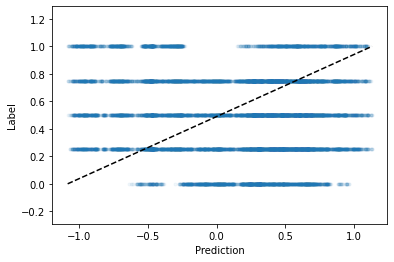

In [9]:
x = mons['y_hat'].flatten()
y = data['test']['Y'].flatten()
plt.plot(x, y, '.', alpha=0.05)
plt.plot([np.amin(x), np.amax(x)],
          [np.amin(y), np.amax(y)], 'k', linestyle='--')
plt.axis('equal')
plt.xlabel('Prediction')
plt.ylabel('Label')

Of course, this untrained network is useless. So let's try training by BPTT, using the "credit assignment vector"

\begin{align}
{\bf q}^{(t)} \equiv \partial \mathcal{L} / \partial {\bf a}^{(t)}.
\end{align}

We can unpack this expression going backwards via

\begin{align}
{\bf c}^{(t'-1)} = {\bf q}^{(t'-1)} + {\bf c}^{(t')} {\bf J}^{(t')}
\end{align}

for any $t'$ in the range from $t - T$ to $t$, where $T$ is the trunction horizon. We start with ${\bf c}^{(t)} = {\bf q}^{(t)}$, calculate each of the ${\bf c}$ values going backwards, and then get an estimate of the gradient at each time step $t'$

\begin{align}
\partial \mathcal{L} / \partial W^{(t')}_{ij} &= {\bf c}^{(t')}_i \partial a^{(t')}_i / \partial W^{(t')}_{ij}\\
&= {\bf c}^{(t')}_i \phi'(h^{(t)}_i) \hat{a}^{(t-1)}_j
\end{align}

We finally sum these up and return it as the gradient.

TODO
1. Write the get_rec_grads method that implements the algorithm above, using the fact that we have already stored the relevant variables at time $t'$ in the lists self.*_history.

In [20]:
class Learning_Algorithm:
    
    """Parent class for all types of learning algorithms.
    Attributes:
        rnn (network.RNN): An instance of RNN to be trained by the network.
        n_* (int): Extra pointer to net.n_* (in, h, out) for conveneince.
        m (int): Number of recurrent "input dimensions" n_h + n_in + 1 including
            task inputs and constant 1 for bias.
        q (numpy array): Array of immediate error signals for the hidden units,
            i.e. the derivative of the current loss with respect to net.a, of
            shape (n_h)."""
    
    def __init__(self, rnn, learning_rate=0.001):
        
        #Define basic learning algorithm properties
        self.rnn = rnn
        self.n_in = self.rnn.n_in
        self.n_h = self.rnn.n_h
        self.n_out = self.rnn.n_out
        self.m = self.n_h + self.n_in + 1
        self.q = np.zeros(self.n_h)
        self.lr = learning_rate
        self.outer_grads = 0

    def get_outer_grads(self):
        """Calculates the derivative of the loss with respect to the output
        parameters net.W_out and net.b_out.

        Calculates the outer gradients in the manner of a perceptron derivative
        by taking the outer product of the error with the "regressors" onto the
        output (the hidden state and constant 1).

        Returns:
            A numpy array of shape (net.n_out, self.n_h + 1) containing the
                concatenation (along column axis) of the derivative of the loss
                w.r.t. net.W_out and w.r.t. net.b_out."""

        self.a_ = np.concatenate([self.rnn.a, np.array([1])])
        return np.multiply.outer(self.rnn.error, self.a_)

    def propagate_feedback_to_hidden(self):
        """Performs one step of backpropagation from the outer-layer errors to
        the hidden state.

        Calculates the immediate derivative of the loss with respect to the
        hidden state rnn.a.

        Updates q to the current value of dL/da."""
        
        self.q = self.rnn.error.dot(self.rnn.W_out)

    def __call__(self):
        """Calculates the final list of grads for this time step.

        Assumes the user has already called self.update()), a
        method specific to each child class. Uses the accumulated
        outer_grads (and resets to 0 after), then calls
        get_rec_grads method (specific to each child class) to get the gradients
        of W_rec, W_in, and b_rec as one numpy array with shape (n_h, m). Then
        these gradients are split along the column axis into a list of 5
        gradients for W_rec, W_in, b_rec, W_out, b_out.

        Returns:
            List of gradients for W_rec, W_in, b_rec, W_out, b_out."""
        
        self.rec_grads = self.get_rec_grads()
        rec_grads_list = split_weight_matrix(self.rec_grads,
                                             [self.n_h, self.n_in, 1])
        outer_grads_list = split_weight_matrix(self.outer_grads,
                                               [self.n_h, 1])
        grads_list = rec_grads_list + outer_grads_list

        #Reset outer grads to 0
        self.outer_grads = 0
        
        return grads_list
    
class BPTT(Learning_Algorithm):
    
    def __init__(self, rnn, T_truncation, learning_rate=0.001):
        
        super().__init__(rnn, learning_rate=learning_rate)
        
        self.T_truncation = T_truncation
        
        #Initialize lists for storing network data
        self.a_hat_history = [np.zeros(self.m)] * self.T_truncation
        self.h_history = [np.zeros(self.n_h)] * self.T_truncation
        self.q_history = [np.zeros(self.n_h)] * self.T_truncation
        
    def update(self):
        
        #Add latest values to list
        self.a_hat = np.concatenate([self.rnn.a_prev,
                                     self.rnn.x,
                                     np.array([1])])
        
        self.a_hat_history.append(self.a_hat)
        
        self.h_history.append(self.rnn.h)
        
        self.propagate_feedback_to_hidden()
        self.q_history.append(self.q)
        
        #Delete old values 
        del(self.a_hat_history[0])
        del(self.h_history[0])
        del(self.q_history[0])
        
        #Accumulate outer grads
        self.outer_grads += self.get_outer_grads()
        
    def get_rec_grads(self):
        
        """ FILL IN FUNCTION 
        
        Using the accumulated history of q, h and a_hat values,
        calculate the gradient of W
        
        Returns:
            rec_grads (numpy array, (n_h, n_h + n_in + 1)): Gradient \partial L / \partial W as computed
                by backpropagating through the unrolled graph.
        """

        #Hint: initialize the desired output to 0
        rec_grads = 0
        #Hint: initialize first c value to the last q value
        c = self.q_history[-1]
        for i_BPTT in range(self.T_truncation):
            
            #Access present values of h and a_hat
            h = self.h_history[-(i_BPTT + 1)]
            a_hat = self.a_hat_history[-(i_BPTT + 1)]
            
            ### TODO ###
            #Write the update for the recurrent gradients (rec_grads) using a_hat, h, and c

            rec_grads += np.outer(c*(self.rnn.activation.f_prime(h)),a_hat)
            
            if i_BPTT == self.T_truncation - 1:
                continue
            
            q = self.q_history[-(i_BPTT + 2)]
            J = self.rnn.get_jacobian(h=h)
            c = q + c.dot(J)
        
        return rec_grads

In [22]:
n_in = 2
n_hidden = 32
n_out = 2

np.random.seed(0)

#Initialize input/output weights as 
W_in  = np.random.normal(0, np.sqrt(1/(n_in)), (n_hidden, n_in))
W_out = np.random.normal(0, np.sqrt(1/(n_hidden)), (n_out, n_hidden))

#Initialize recurrent weights with a random *orthogonal* matrix
W_rec = np.linalg.qr(np.random.normal(0, 1, (n_hidden, n_hidden)))[0]

#Initialize biases to 0
b_rec = np.zeros(n_hidden)
b_out = np.zeros(n_out)

#Initialize RNN object with these initial weights, \phi = tanh, \psi = I, L = MSE
rnn = RNN(W_in, W_rec, W_out, b_rec, b_out,
          activation=tanh,
          output=identity,
          loss=mean_squared_error)

T_truncation = 15
learning_rate = 0.001
learn_alg = BPTT(rnn, T_truncation=T_truncation, learning_rate=learning_rate)

rnn, mons = simulate(rnn, data, mode='train', learn_alg=learn_alg)

Progress: 10.0% complete 
Time Elapsed: 0.8s 

Progress: 20.0% complete 
Time Elapsed: 1.5s 

Progress: 30.0% complete 
Time Elapsed: 2.3s 

Progress: 40.0% complete 
Time Elapsed: 3.0s 

Progress: 50.0% complete 
Time Elapsed: 3.8s 

Progress: 60.0% complete 
Time Elapsed: 4.6s 

Progress: 70.0% complete 
Time Elapsed: 5.3s 

Progress: 80.0% complete 
Time Elapsed: 6.0s 

Progress: 90.0% complete 
Time Elapsed: 6.8s 



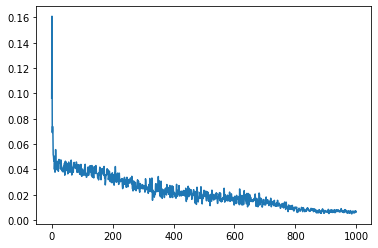

In [23]:
### --- PLOT TRAINING LOSS --- ###
filtered_loss = decimate(decimate(mons['loss_'], 10), 10)
plt.plot(filtered_loss)

In [25]:
### --- RUN TEST SIMULATION --- ###
rnn, mons = simulate(rnn, data, mode='test')

Text(0, 0.5, 'Label')

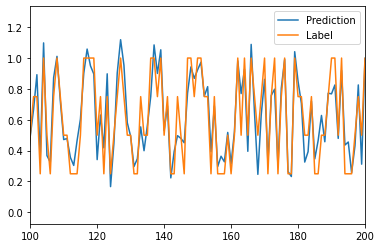

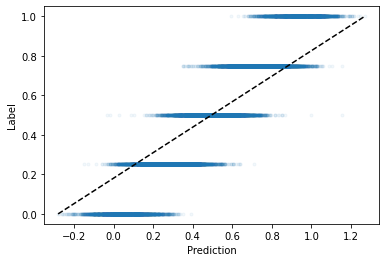

In [15]:
### --- PLOT RESULTS --- ###
plt.figure()
plt.plot(mons['y_hat'][:,0])
plt.plot(data['test']['Y'][:,0])
plt.legend(['Prediction', 'Label'])
plt.xlim([100, 200])
plt.figure()
x = mons['y_hat'].flatten()
y = data['test']['Y'].flatten()
plt.plot(x, y, '.', alpha=0.05)
plt.plot([np.amin(x), np.amax(x)],
          [np.amin(y), np.amax(y)], 'k', linestyle='--')
plt.axis('equal')
plt.xlabel('Prediction')
plt.ylabel('Label')

FINAL TASKS

TO DO 1:
Verify that your learning algorithm is working. Then rerun it for different values of the truncation horizon (T_truncation) and describe how performance degrades or saturates. Can you explain the results given the information about the dataset?

## Please turn in the code and pdf before 12/07/2020 at 11:59 pm. Please name your notebook netid.ipynb.

### Your work will be evaluated based on the code, plots, AND question answers (this is NEW!). 

TO DO 1: Verify that your learning algorithm is working. Then rerun it for different values of the truncation horizon (T_truncation) and describe how performance degrades or saturates. Can you explain the results given the information about the dataset?

In [41]:
n_in = 2
n_hidden = 32
n_out = 2

np.random.seed(0)

#Initialize input/output weights as 
W_in  = np.random.normal(0, np.sqrt(1/(n_in)), (n_hidden, n_in))
W_out = np.random.normal(0, np.sqrt(1/(n_hidden)), (n_out, n_hidden))

#Initialize recurrent weights with a random *orthogonal* matrix
W_rec = np.linalg.qr(np.random.normal(0, 1, (n_hidden, n_hidden)))[0]

#Initialize biases to 0
b_rec = np.zeros(n_hidden)
b_out = np.zeros(n_out)

#Initialize RNN object with these initial weights, \phi = tanh, \psi = I, L = MSE


#T_truncation = 15
T_truncation_list = [3, 10, 15,20, 30, 35]
rnn_dict = dict()
loss = dict()
for T_truncation in T_truncation_list:
  rnn = RNN(W_in, W_rec, W_out, b_rec, b_out,
          activation=tanh,
          output=identity,
          loss=mean_squared_error)

  learning_rate = 0.001
  learn_alg = BPTT(rnn, T_truncation=T_truncation, learning_rate=learning_rate)

  rnn, mons = simulate(rnn, data, mode='train', learn_alg=learn_alg)
  rnn_dict[T_truncation] = rnn
  filtered_loss = decimate(decimate(mons['loss_'], 10), 10)
  loss[T_truncation] = filtered_loss
#plt.plot(filtered_loss)

Progress: 10.0% complete 
Time Elapsed: 0.9s 

Progress: 20.0% complete 
Time Elapsed: 1.9s 

Progress: 30.0% complete 
Time Elapsed: 2.8s 

Progress: 40.0% complete 
Time Elapsed: 3.7s 

Progress: 50.0% complete 
Time Elapsed: 4.7s 

Progress: 60.0% complete 
Time Elapsed: 5.6s 

Progress: 70.0% complete 
Time Elapsed: 6.5s 

Progress: 80.0% complete 
Time Elapsed: 7.4s 

Progress: 90.0% complete 
Time Elapsed: 8.3s 

Progress: 10.0% complete 
Time Elapsed: 0.8s 

Progress: 20.0% complete 
Time Elapsed: 1.5s 

Progress: 30.0% complete 
Time Elapsed: 2.3s 

Progress: 40.0% complete 
Time Elapsed: 3.1s 

Progress: 50.0% complete 
Time Elapsed: 3.9s 

Progress: 60.0% complete 
Time Elapsed: 4.7s 

Progress: 70.0% complete 
Time Elapsed: 5.5s 

Progress: 80.0% complete 
Time Elapsed: 6.3s 

Progress: 90.0% complete 
Time Elapsed: 7.0s 

Progress: 10.0% complete 
Time Elapsed: 0.7s 

Progress: 20.0% complete 
Time Elapsed: 1.5s 

Progress: 30.0% complete 
Time Elapsed: 2.3s 

Progress: 40.

Text(0.5, 1.0, 'loss')

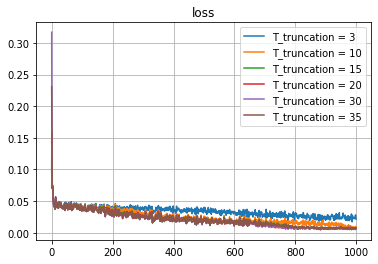

In [42]:
for key in T_truncation_list:
  plt.plot(loss[key], label = 'T_truncation = ' + str(key))
plt.grid()
plt.legend()
plt.title('loss')

As we can see the above figure, when T_truncatino = 3, the loss decrease very slowly, which means that we need more epoches to train model. \\
In addition, when T_truncation is more than 15, the loss values tend to saturate as the number of epoches increase. \\

In a nutshell, when we reduce the length of 'truncation horizon', the model does not learn data quickly, but too long 'truncation horizon' shows the same performance as that of an optimal length for learning (too long length causes unecessary computation complexity). 

**When T_truncation = 3, we can observe that the model doesn't show good accuracy as the following.** 🙅

Text(0, 0.5, 'Label')

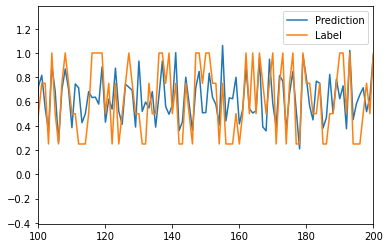

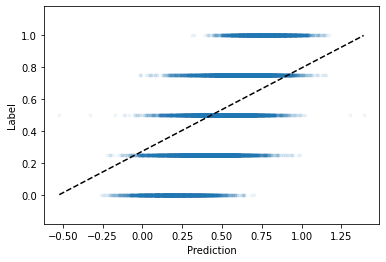

In [46]:
### --- RUN TEST SIMULATION --- ###
rnn, mons = simulate(rnn_dict[3], data, mode='test')
### --- PLOT RESULTS --- ###
plt.figure()
plt.plot(mons['y_hat'][:,0])
plt.plot(data['test']['Y'][:,0])
plt.legend(['Prediction', 'Label'])
plt.xlim([100, 200])
plt.figure()
x = mons['y_hat'].flatten()
y = data['test']['Y'].flatten()
plt.plot(x, y, '.', alpha=0.05)
plt.plot([np.amin(x), np.amax(x)],
          [np.amin(y), np.amax(y)], 'k', linestyle='--')
plt.axis('equal')
plt.xlabel('Prediction')
plt.ylabel('Label')

**However, when T_truncation = 20, the model shows the same performance as the case of T_truncation = 15**🙂

Text(0, 0.5, 'Label')

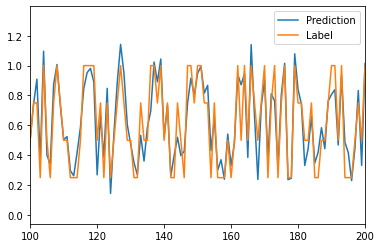

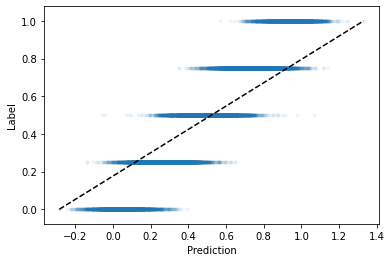

In [47]:
### --- RUN TEST SIMULATION --- ###
rnn, mons = simulate(rnn_dict[20], data, mode='test')
### --- PLOT RESULTS --- ###
plt.figure()
plt.plot(mons['y_hat'][:,0])
plt.plot(data['test']['Y'][:,0])
plt.legend(['Prediction', 'Label'])
plt.xlim([100, 200])
plt.figure()
x = mons['y_hat'].flatten()
y = data['test']['Y'].flatten()
plt.plot(x, y, '.', alpha=0.05)
plt.plot([np.amin(x), np.amax(x)],
          [np.amin(y), np.amax(y)], 'k', linestyle='--')
plt.axis('equal')
plt.xlabel('Prediction')
plt.ylabel('Label')

**So when T_truncation > 15, the model shows the saturation of the learning for the given data.**
